In [14]:
import sys, os, re
import json
import datetime, iso8601

base_path = ".."

## Setup PySpark Environment

In [15]:
APP_NAME = "Debugging Prediction Problems"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

## Load Training DataFrame

In [19]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),  # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),  # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),  # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),  # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True),  # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),  # "DepDelay":14.0
  StructField("Dest", StringType(), True),  # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),  # "Distance":368.0
  StructField("FlightDate", DateType(), True),  # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),  # "FlightNum":"6109"
  StructField("Origin", StringType(), True),  # "Origin":"TUS"
])

input_path = "{}/data/simple_flight_delay_features.json".format(base_path)

features = spark.read.json(
  input_path,
  schema=schema
)
features.select("ArrDelay", "CRSArrTime", "CRSDepTime", "Carrier", "DepDelay", 
                "Origin", "Dest", "FlightDate", "FlightNum", "Distance").show(12)

+--------+--------------------+--------------------+-------+--------+------+----+----------+---------+--------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DepDelay|Origin|Dest|FlightDate|FlightNum|Distance|
+--------+--------------------+--------------------+-------+--------+------+----+----------+---------+--------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|    14.0|   ABQ| DFW|2014-12-31|     1024|   569.0|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|    14.0|   ABQ| DFW|2014-12-31|     1184|   569.0|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|    -2.0|   ABQ| DFW|2014-12-31|      336|   569.0|
|   -21.0|2015-01-01 11:30:...|2015-01-01 09:55:...|     AA|    -1.0|   ATL| DFW|2014-12-31|      125|   731.0|
|   -14.0|2015-01-01 02:25:...|2015-01-01 00:55:...|     AA|    -4.0|   ATL| DFW|2014-12-31|     1455|   731.0|
|    16.0|2015-01-01 07:15:...|2015-01-01 05:45:...|     AA|    15.0|   ATL| DFW|2014-12-31|     1473|  

## Reproduce the ArrDelay Bucketing

In [21]:
# Load the arrival delay bucketizer
from pyspark.ml.feature import Bucketizer

# Load the departure delay bucketizer
arrival_bucketizer_path = "{}/models/arrival_bucketizer.bin".format(base_path)
arrival_bucketizer = Bucketizer.load(arrival_bucketizer_path)

# Bucketize the departure and arrival delays for classification
ml_bucketized_features = arrival_bucketizer.transform(features)
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show(10)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           0.0|
|    17.0|           1.0|
|    36.0|           1.0|
|   -21.0|           0.0|
|   -14.0|           0.0|
|    16.0|           1.0|
|    -7.0|           0.0|
|    13.0|           0.0|
|    25.0|           1.0|
|    58.0|           1.0|
+--------+--------------+
only showing top 10 rows



## Check the `ArrDelayBucket` Distribution

In [23]:
# Check the frequency of each category
ml_bucketized_features.registerTempTable("ml_bucketized_features")

spark.sql(
"""
SELECT
  ArrDelayBucket,
  COUNT(*) AS Total,
  ROUND(
    100 * (COUNT(*)/(SELECT COUNT(*) FROM ml_bucketized_features)),
    2
  ) AS Total_Pct
FROM ml_bucketized_features
GROUP BY ArrDelayBucket
"""
).show()

+--------------+-------+---------+
|ArrDelayBucket|  Total|Total_Pct|
+--------------+-------+---------+
|           0.0|4650569|    81.39|
|           1.0| 737848|    12.91|
|           2.0| 325591|      5.7|
+--------------+-------+---------+



The results are pretty skewed, with 81.4% in `ArrDelayBucket` `0.0`. Note that our model always predicts `0.0`...

## Sampling `ArrDelayBucket` `0.0`
Lets take a look at some example values in the largest bucket, bucket `0.0`. Lets sample it before we inspect it.

In [26]:
# Check out some values from the field
spark.sql("SELECT ArrDelay, ArrDelayBucket "
          "FROM ml_bucketized_features "
          "WHERE ArrDelayBucket == 0.0")\
  .sample(False, 0.01, 11).show(15)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|   -31.0|           0.0|
|   -26.0|           0.0|
|    -7.0|           0.0|
|    -9.0|           0.0|
|    -7.0|           0.0|
|     6.0|           0.0|
|     0.0|           0.0|
|    -2.0|           0.0|
|   -15.0|           0.0|
|   -21.0|           0.0|
|    -5.0|           0.0|
|    10.0|           0.0|
|   -13.0|           0.0|
|   -21.0|           0.0|
|   -21.0|           0.0|
+--------+--------------+
only showing top 15 rows



There looks to be a pretty broad range of values in `ArrDelayBucket` `0.0`...

## Computing `ArrDelayBucket` Scope
Lets look at the `MIN` and `MAX` values of `ArrDelay` in `ArrDelayBucket` `0.0`.

In [27]:
# Check out the min/max for the field
spark.sql("SELECT MIN(ArrDelay), MAX(ArrDelay) "
          "FROM ml_bucketized_features "
          "WHERE ArrDelayBucket == 0.0").show()

+-------------+-------------+
|min(ArrDelay)|max(ArrDelay)|
+-------------+-------------+
|        -87.0|         14.0|
+-------------+-------------+



There is a range of 101 in this bucket. This encodes a large range... from 14 minute late all the way to over an hour early.

## Histogram of `ArrDelay` in `ArrDelayBucket` `0.0`
Now, what is the distribution of values in `ArrDelayBucket` `0.0`? I want to get a sense of what this bucket encodes. We can filter to a relation with only `ArrDelayBucket` values of `0.0`, convert our `DataFrame` to an `RDD` and then use the [`RDD.histogram()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.histogram) function to get the raw data for our histogram. 

### Baseline Histgoram of Overall Data
First, however, I need the histogram of the entire range of data to compare this to. We need to supply our own buckets, or the histogram is hard to interpret.

In [28]:
# Look at overall histogram
ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-87.0, -60, -30, -15, 0, 15, 30, 60, 120])

([-87.0, -60, -30, -15, 0, 15, 30, 60, 120],
 [392, 108707, 989113, 2402687, 1149670, 412835, 325013, 211171])

### Creating a PyPlot Bar Chart
We must use [matplotlib.pyplot.bar](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar) instead of [matplotlib.pyplot.hist](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist) because we have already computed our bins and their weights.

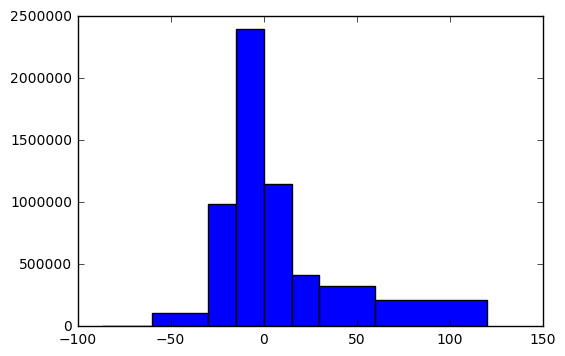

In [58]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Look at overall histogram
data_tuple = ml_bucketized_features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-87.0, -60, -30, -15, 0, 15, 30, 60, 120])

heights = np.array(data_tuple[1])

# The bins are 1 > length than the values
full_bins = data_tuple[0]

# Bars are drawn from the left
mid_point_bins = full_bins[:-1]

# The width of a bar should be the range it maps in the data
widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]

# And now the bar should plot nicely
bar = plt.bar(mid_point_bins, weights, width=widths, color='b')

We can see here that there is a strong mean in our data around 0-15, and that most of the data was falling either in `ArrDelayBucket` `0.0` or very nearly so in the next bin. This must make the bins hard to reckon for the classifier.